In [1]:
# Imports
import os, sys
import numpy as np
import ROOT as rt
import uproot
import h5py
import matplotlib.pyplot as plt
import root_numpy as rtnp
import pandas
from math import log10, floor
import math
from subprocess import Popen
import shlex 
import cmsstyle


Welcome to JupyROOT 6.12/07


In [2]:
# Input: Trainings with different amount of injected signal
signal  = 'sig_GtoWW35naReco'
xsecs   = [0,10,100]

In [3]:
files_signal = {}
files_qcd = {}
for xs in xsecs:
    
    path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/{}/xsec_{}/'.format(signal,xs)
    if xs == 0:
        path = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_results/run_113/{}/xsec_{}/loss_rk5_05/'.format(signal,xs)
        
    f_qcd = h5py.File(path+'qcd_sqrtshatTeV_13TeV_PU40_NEW_ALL_Test_reco.h5', 'r')
    f_sig = h5py.File(path+'RSGraviton_WW_NARROW_13TeV_PU40_3.5TeV_reco.h5', 'r')
    files_signal[xs] = f_sig
    files_qcd[xs] = f_qcd

for xs in xsecs:
    f_qcd = files_qcd[xs]
    f_sig = files_signal[xs]

In [4]:
# Rescaling the inputs to lumi
qcd_xsec       = 8730000.0 # Crossection in fb             
qcd_gen_events = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec       = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events = 972050.0 #(all generated signal)
lumi           = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = 0.8*sig_xsec*lumi/sig_gen_events #20% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.981237457
Scale QCD with 1.0
Scale signal with 0.000526567460168


In [5]:
# Set binning
useDijet = True

# Dijet variable-binwidth binning (depends on dijet resolution)
if useDijet:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084, 4245, 
                          4411, 4583, 4760, 4943, 5132, 5327,
                          5574, 5737, 5951, 6173, 6402, 6638, 6882]).astype('float')
if useDijet:
    bin_edges = np.array([1200, 1255, 1320, 1387, 1457, 1529,
                          1604, 1681, 1761, 1844, 1930, 2019, 
                          2111, 2206, 2305, 2406, 2512, 2620, 
                          2733, 2849, 2969, 3093, 3221, 3353,
                          3490, 3632, 3778, 3928, 4084]).astype('float')
# Constant binwidth
else:
    bin_edges = np.array(np.arange(1200.,4000., 100.).tolist()).astype('float') #100 GeV binning. Stop at 5600! Fit fails if going to 6800


n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]
bws = (max_bin-min_bin)/n_bins

print(bin_edges)
print('Nbins = {} width = {}'.format(n_bins,bws))


[1200. 1255. 1320. 1387. 1457. 1529. 1604. 1681. 1761. 1844. 1930. 2019.
 2111. 2206. 2305. 2406. 2512. 2620. 2733. 2849. 2969. 3093. 3221. 3353.
 3490. 3632. 3778. 3928. 4084.]
Nbins = 28 width = 103.0


In [7]:
# DEFINE NON-ORTHOGONAL QUANTILES

datas_qcd = {}
datas_sig = {}

datas_qcd_rejected = {}
datas_sig_rejected = {}
# Create datasets
for xs in xsecs:

    f_qcd = files_qcd[xs]
    f_sig = files_signal[xs]
    
    # Different quantiles (not orthogonal!)
    columns   = {}
    columns[0.9]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q90')[0]) # 0=rejected 1=accepted
    columns[0.7]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q70')[0])
    columns[0.5]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q50')[0])
    columns[0.3]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q30')[0])
    columns[0.1]  = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q10')[0])
    columns[0.01] = int(np.where(f_qcd['eventFeatureNames'][()] == 'sel_q01')[0])
    
    
    mjj_idx  = int(np.where(f_qcd['eventFeatureNames'][()] == 'mJJ')[0])
    deta_idx = int(np.where(f_qcd['eventFeatureNames'][()] == 'DeltaEtaJJ')[0])

    # Get all features as numpy arrays and apply dEta cut
    
    qcd_tot = np.array(f_qcd.get("eventFeatures"))
    sig_tot = np.array(f_sig.get("eventFeatures"))
    qcd_tot = qcd_tot[abs(qcd_tot[:,deta_idx]) < 1.40]
    sig_tot = sig_tot[abs(sig_tot[:,deta_idx]) < 1.40]
    
#     datas_qcd_acc = {}
#     datas_sig_acc = {}
#     datas_qcd_rej = {}
#     datas_sig_rej = {}
#     for key in sorted(columns.keys()):
#         datas_qcd_acc[key] = qcd_tot[qcd_tot[:,columns[key]] == 1]
#         datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]
#         datas_sig_acc[key] = sig_tot[sig_tot[:,columns[key]] == 1]
#         datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]
        
#         datas_qcd_rej[key] = qcd_tot[qcd_tot[:,columns[key]] == 0]
#         datas_qcd_rej[key] = datas_qcd_rej[key][:,mjj_idx]
#         datas_sig_rej[key] = sig_tot[sig_tot[:,columns[key]] == 0]
#         datas_sig_rej[key] = datas_sig_rej[key][:,mjj_idx]
        

#     datas_qcd[xs] = datas_qcd_acc
#     datas_sig[xs] = datas_sig_acc
#     datas_qcd_rejected[xs] = datas_qcd_rej
#     datas_sig_rejected[xs] = datas_sig_rej
    
    # DEFINE ORTHOGONAL QUANTILES
    
    

  
    qcd = np.copy(qcd_tot)
    sig = np.copy(sig_tot)
    
    datas_qcd_acc = {}
    datas_sig_acc = {}
    
    #Define the main templates as the 'unused quantile' at 90-100% background efficiency
    datas_qcd_acc[1.0] = qcd_tot[qcd_tot[:,columns[0.9]] == 0]
    datas_qcd_acc[1.0] = datas_qcd_acc[1.0][:,mjj_idx]
    datas_sig_acc[1.0] = sig_tot[sig_tot[:,columns[0.9]] == 0]
    datas_sig_acc[1.0] = datas_sig_acc[1.0][:,mjj_idx]
    
    for key in sorted(columns.keys()):

        # Start with q=0.01 and take all events that pass cut on VAE
        datas_qcd_acc[key] = qcd[qcd[:,columns[key]] == 1]
        datas_qcd_acc[key] = datas_qcd_acc[key][:,mjj_idx]

        datas_sig_acc[key] = sig[sig[:,columns[key]] == 1]
        datas_sig_acc[key] = datas_sig_acc[key][:,mjj_idx]

        #Remove those events from dataset and continue to next quantile
        qcd = qcd[qcd[:,columns[key]] == 0]
        sig = sig[sig[:,columns[key]] == 0]

    datas_qcd[xs] = datas_qcd_acc
    datas_sig[xs] = datas_sig_acc
    
    # Sanity checks

    #Check that sum of orthogonal quantiles yield total
    print('N total data events = {}'.format(qcd_tot.shape[0]))
    sum_quantiles = 0
    for i,key in enumerate(sorted(datas_qcd_acc.keys())):
        sum_quantiles += datas_qcd_acc[key].shape[0]
    print('Sum of all events = {}'.format(sum_quantiles))

N total data events = 7671753
Sum of all events = 7671753
N total data events = 7671753
Sum of all events = 7671753
N total data events = 7671753
Sum of all events = 7671753


In [8]:
# Fill histograms

scaled_histos_qcd = {}
scaled_histos_data = {}
scaled_histos_signal = {}

# scaled_histos_qcd_rej = {}
# scaled_histos_data_rej = {}
# scaled_histos_signal_rej = {}
    
for ii,xs in enumerate(xsecs):
    
    datas_qcd_acc = datas_qcd[xs]  
    datas_sig_acc = datas_sig[xs] 
    
#     datas_qcd_rej = datas_qcd_rejected[xs] 
#     datas_sig_rej = datas_sig_rejected[xs] 
    
    histos_qcd = {}
    histos_data = {}
    histos_signal = {}
    
#     histos_qcd_rej = {}
#     histos_data_rej = {}
#     histos_signal_rej = {}
    
    axis_title = ['M_{jj}','Events']
    scol = ['#fdcc8a','#fc8d59','#d7301f']
    bcol = ['#bdc9e1','#67a9cf','#02818a']

    for i,(keyD,keyS) in enumerate(zip( sorted(datas_qcd_acc.keys()), sorted(datas_sig_acc.keys()) )):
        histos_qcd[keyD]  = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
        histos_signal[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
        rtnp.fill_hist(histos_qcd[keyD]   , datas_qcd_acc[keyD], weights=None)
        rtnp.fill_hist(histos_signal[keyS] , datas_sig_acc[keyS], weights=None)

        # Scale signal by the crossection injected (default is 10 fb)
        if xs == 0:
            scale = 0.01
        else:
            scale = xs/10.
        histos_signal[keyS].Scale(scale_sig*scale)

        histos_qcd[keyD]  .SetStats(0)
        histos_signal[keyS].SetStats(0)

        histos_qcd[keyD].Sumw2()
        histos_signal[keyS].Sumw2()
        
        NQCD       = int(histos_qcd[keyD].Integral())
        NSIG       = int(histos_signal[keyS].Integral())
        SB         = NSIG/np.sqrt(NQCD)
        print("xs={} q={} S/sqrt(B)={}".format(xs,keyD,SB))

        histos_qcd[keyD].SetXTitle(axis_title[0])
        histos_qcd[keyD].SetYTitle(axis_title[1])
        histos_qcd[keyD].binning = bin_edges

        histos_signal[keyS].SetXTitle(axis_title[0])
        histos_signal[keyS].SetYTitle(axis_title[1])
        histos_signal[keyS].binning = bin_edges

        histos_qcd[keyD].SetLineColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[ii]))
        histos_qcd[keyD].SetLineStyle(1)
        
        histos_signal[keyS].SetLineColor(rt.TColor.GetColor(scol[ii]))
        histos_signal[keyS].SetLineStyle(1)
        histos_signal[keyS].SetLineWidth(2)
#         histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[ii])), 0.30)

        histos_qcd[keyD].SetMarkerStyle(20)
        histos_qcd[keyD].SetMarkerSize(0.9)
        
        histos_data[keyD] = histos_qcd[keyD].Clone('data_{}_{}'.format(xs,keyD))
        if xs != 0:
            histos_data[keyD].Add(histos_signal[keyS])
        histos_data[keyD].Sumw2()
                                  
    
    scaled_histos_data[xs]   = histos_data
    scaled_histos_qcd[xs]    = histos_qcd
    scaled_histos_signal[xs] = histos_signal         
    
#     for i,(keyD,keyS) in enumerate(zip( sorted(datas_qcd_rej.keys()), sorted(datas_sig_rej.keys()) )):
#         histos_qcd_rej[keyD]   = rt.TH1D('data_obs_{}'.format(keyD),'',n_bins,bin_edges.astype('float'))
#         histos_signal_rej[keyS]= rt.TH1D('signal_{}'  .format(keyS),'',n_bins,bin_edges.astype('float'))
#         rtnp.fill_hist(histos_qcd_rej[keyD]   , datas_qcd_rej[keyD], weights=None)
#         rtnp.fill_hist(histos_signal_rej[keyS], datas_sig_rej[keyS], weights=None)

#         # Scale signal by the crossection injected (default is 10 fb)

#         if xs == 0:
#             scale = 0.1
#         else:
#             scale = xs/10.
#         histos_signal_rej[keyS].Scale(scale_sig*scale)

#         histos_qcd_rej[keyD]  .SetStats(0)
#         histos_signal_rej[keyS].SetStats(0)

#         histos_qcd_rej[keyD].Sumw2()
#         histos_signal_rej[keyS].Sumw2()

#         histos_qcd_rej[keyD].SetXTitle(axis_title[0])
#         histos_qcd_rej[keyD].SetYTitle(axis_title[1])
#         histos_qcd_rej[keyD].binning = bin_edges

#         histos_signal_rej[keyS].SetXTitle(axis_title[0])
#         histos_signal_rej[keyS].SetYTitle(axis_title[1])
#         histos_signal_rej[keyS].binning = bin_edges

#         histos_qcd_rej[keyD].SetLineColor(rt.TColor.GetColor(bcol[ii]))
#         histos_qcd_rej[keyD].SetMarkerColor(rt.TColor.GetColor(bcol[ii]))
#         histos_qcd_rej[keyD].SetLineStyle(3)
        
#         histos_signal_rej[keyS].SetLineColor(rt.TColor.GetColor(scol[ii]))
#         histos_signal_rej[keyS].SetLineStyle(3)
#         histos_signal_rej[keyS].SetLineWidth(2)
# #         histos_signal[keyS].SetFillColorAlpha((rt.TColor.GetColor(scol[ii])), 0.30)

#         histos_qcd_rej[keyD].SetMarkerStyle(24)
#         histos_qcd_rej[keyD].SetMarkerSize(0.9)
        
#         histos_data_rej[keyD] = histos_qcd_rej[keyD].Clone('data_{}_{}'.format(xs,keyD))
#         if xs != 0:
#             histos_data_rej[keyD].Add(histos_signal_rej[keyS])
#         histos_data_rej[keyD].Sumw2()
                                  
    
#     scaled_histos_data_rej[xs]   = histos_data_rej
#     scaled_histos_qcd_rej[xs]    = histos_qcd_rej
#     scaled_histos_signal_rej[xs] = histos_signal_rej    

xs=0 q=0.01 S/sqrt(B)=0.0
xs=0 q=0.1 S/sqrt(B)=0.0
xs=0 q=0.3 S/sqrt(B)=0.0
xs=0 q=0.5 S/sqrt(B)=0.0
xs=0 q=0.7 S/sqrt(B)=0.0
xs=0 q=0.9 S/sqrt(B)=0.0
xs=0 q=1.0 S/sqrt(B)=0.0
xs=10 q=0.01 S/sqrt(B)=0.0251175328569
xs=10 q=0.1 S/sqrt(B)=0.0709151006823
xs=10 q=0.3 S/sqrt(B)=0.0743678467259
xs=10 q=0.5 S/sqrt(B)=0.0411951674736
xs=10 q=0.7 S/sqrt(B)=0.0274882152596
xs=10 q=0.9 S/sqrt(B)=0.0185154999931
xs=10 q=1.0 S/sqrt(B)=0.0102976041648
xs=100 q=0.01 S/sqrt(B)=0.248932068461
xs=100 q=0.1 S/sqrt(B)=0.649594711721
xs=100 q=0.3 S/sqrt(B)=0.713252291989
xs=100 q=0.5 S/sqrt(B)=0.44235686723
xs=100 q=0.7 S/sqrt(B)=0.30027205928
xs=100 q=0.9 S/sqrt(B)=0.206534641044
xs=100 q=1.0 S/sqrt(B)=0.121314105173


Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure al

In [9]:
import cmsstyle #mplhep for Python2 cheatsheet

def drawHistos(qPass=0.1,qFail=0.9):
    c_out = rt.TCanvas("ratio_qacc{}_qrej{}".format(qPass,qFail), "", 1000, 1000)
    pad1 = rt.TPad("pad1_qacc{}_qrej{}".format(qPass,qFail), "pad1_qacc{}_qrej{}".format(qPass,qFail), 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.001)
    pad1.SetLeftMargin(0.13)
    # pad1.SetGridx()
    pad1.Draw()
    pad1.cd()
    leg = rt.TLegend(0.22, 0.6, 0.89, 0.90)
    leg.SetNColumns(2)
    leg.SetTextSize(0.045)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)

#     scaled_histos_data_rej[0][qFail].Draw('PEZ')
#     scaled_histos_data_rej[10][qFail].Draw('PEZsame')
#     scaled_histos_data_rej[100][qFail].Draw('PEZsame')

    scaled_histos_data[0][qFail].Draw('HIST')
    scaled_histos_data[10][qFail].Draw('HISTsame')
    scaled_histos_data[100][qFail].Draw('HISTsame')
    
    scaled_histos_data[0][qPass].Draw('PEZsame')
    scaled_histos_data[10][qPass].Draw('PEZsame')
    scaled_histos_data[100][qPass].Draw('PEZsame')

    scaled_histos_signal[10][qPass].Draw('HISTsame')
    scaled_histos_signal[100][qPass].Draw('HISTsame')


    scaled_histos_data[0][qFail].SetTitle("")
    scaled_histos_data[0][qFail].SetMinimum(0.9)
    scaled_histos_data[0][qFail].GetYaxis().SetTitleSize(0.05)
    scaled_histos_data[0][qFail].GetYaxis().SetLabelSize(0.05)
    scaled_histos_data[0][qFail].GetYaxis().SetTitleOffset(0.95)
    scaled_histos_data[0][qFail].SetMaximum(qcd_tot.shape[0]*1.2)
    scaled_histos_data[0][qFail].GetYaxis().SetNdivisions(304)

    leg.AddEntry(scaled_histos_data[0][qPass] , 'Inj. 0 fb:     Data q = {}'.format(qPass), 'lep') 
    leg.AddEntry(scaled_histos_data[0][qFail] , 'q = {}'.format(qFail), 'l') 

    leg.AddEntry(scaled_histos_data[10][qPass] , 'Inj. 10 fb:   Data q = {}'.format(qPass), 'lep')
    leg.AddEntry(scaled_histos_data[10][qFail] ,'q = {}'.format(qFail), 'l')

    leg.AddEntry(scaled_histos_data[100][qPass] , 'Inj. 100 fb: Data q = {}'.format(qPass), 'lep') 
    leg.AddEntry(scaled_histos_data[100][qFail] , 'q = {}'.format(qFail), 'l') 

    leg.AddEntry(scaled_histos_signal[10][0.1] , 'G(#sigma = 10 fb)', 'l') 
    leg.AddEntry(scaled_histos_signal[100][0.1] , 'G(#sigma = 100 fb)', 'l') 


    leg.Draw('same')

    pad1.SetLogy()
    pad1.SetTitle('')
    pad1.Update()
    c_out.cd()
    pad2 = rt.TPad("pad2_qacc{}_qrej{}".format(qPass,qFail), "pad2_qacc{}_qrej{}".format(qPass,qFail), 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.00)
    pad2.SetBottomMargin(0.27)
    pad2.SetLeftMargin(0.13)
    # pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    data_hist_ratio = {}
    tline = {}
    for xs in xsecs:

        data_hist_ratio[xs] = scaled_histos_data[xs][qPass].Clone('data_hist_ratio_{}'.format(i))
        data_hist_ratio[xs].Divide( scaled_histos_data[xs][qFail])
    #     data_hist_ratio[xs].Scale( scaled_histos_data_rej[xs][qFail].Integral()/scaled_histos_data[xs][qPass].Integral())
        data_hist_ratio[xs].binning = bin_edges
        if xs == 0:
            data_hist_ratio[xs].SetTitle('')
            data_hist_ratio[xs].Draw('pez')
            eff = scaled_histos_data[xs][qPass].Integral()/scaled_histos_data[xs][qFail].Integral()
            data_hist_ratio[xs].SetMaximum(eff*1.5)
            data_hist_ratio[xs].SetMinimum(eff*0.5)
#             data_hist_ratio[xs].SetYTitle('#frac{#epsilon#timesq}{q_{0.9-1.0}}')
            data_hist_ratio[xs].SetYTitle('#frac{Acc.}{Rej.}')
            data_hist_ratio[xs].GetYaxis().CenterTitle()
            data_hist_ratio[xs].SetXTitle('M_{jj} (GeV)')
            data_hist_ratio[xs].GetYaxis().SetTitleOffset(0.4)
            data_hist_ratio[xs].GetYaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetYaxis().SetNdivisions(304)
            data_hist_ratio[xs].GetXaxis().SetNdivisions(909)
            data_hist_ratio[xs].GetXaxis().SetTitleOffset(0.95)
            data_hist_ratio[xs].GetXaxis().SetTitleSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetLabelSize(0.12)
            data_hist_ratio[xs].GetXaxis().SetTickSize(0.07)
        else:
            data_hist_ratio[xs].Draw('pez same')


    #     tline[key] = rt.TLine(min_bin, (key-lower_bound)/0.1, max_bin, (key-lower_bound)/0.1)
        
        tline[xs] = rt.TLine(min_bin, eff, max_bin, eff)
        tline[xs].SetLineColor(rt.kBlack)
        tline[xs].SetLineStyle(rt.kDashed)
        tline[xs].Draw('same')
    pad2.Update()
    c_out.Update()
    c_out.SaveAs("mjj_q{}.pdf".format(qPass))
    return c_out, leg, tline[0], data_hist_ratio

Info in <TCanvas::Print>: pdf file mjj_q0.01.pdf has been created
Info in <TCanvas::Print>: pdf file mjj_q0.1.pdf has been created
Info in <TCanvas::Print>: pdf file mjj_q0.3.pdf has been created
Info in <TCanvas::Print>: pdf file mjj_q0.5.pdf has been created
Info in <TCanvas::Print>: pdf file mjj_q0.7.pdf has been created
Info in <TCanvas::Print>: pdf file mjj_q0.9.pdf has been created


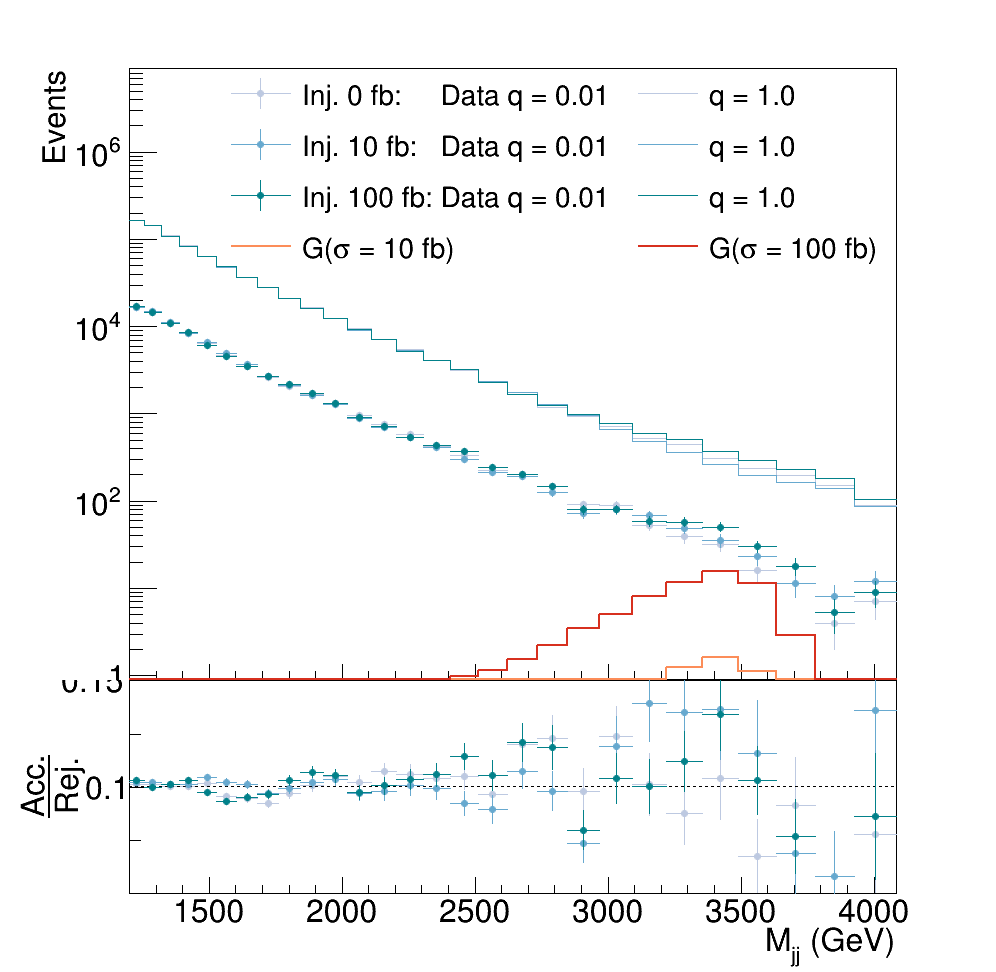

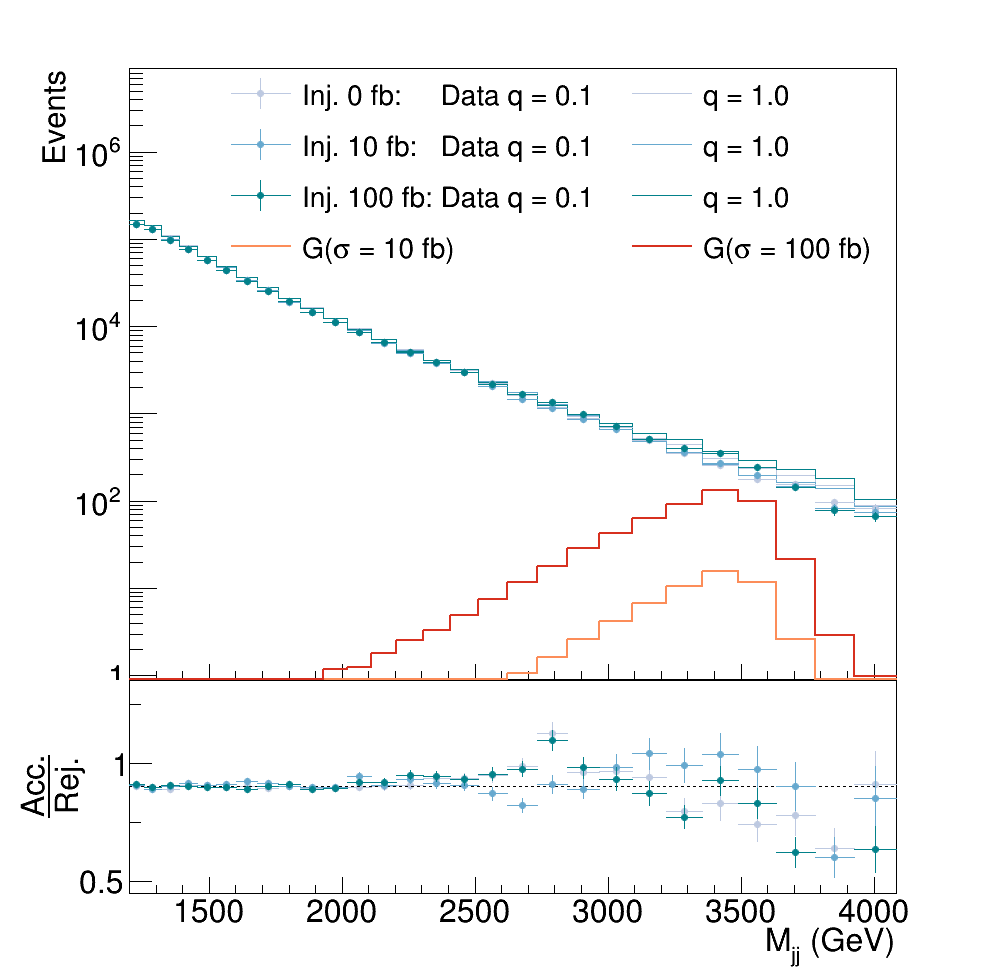

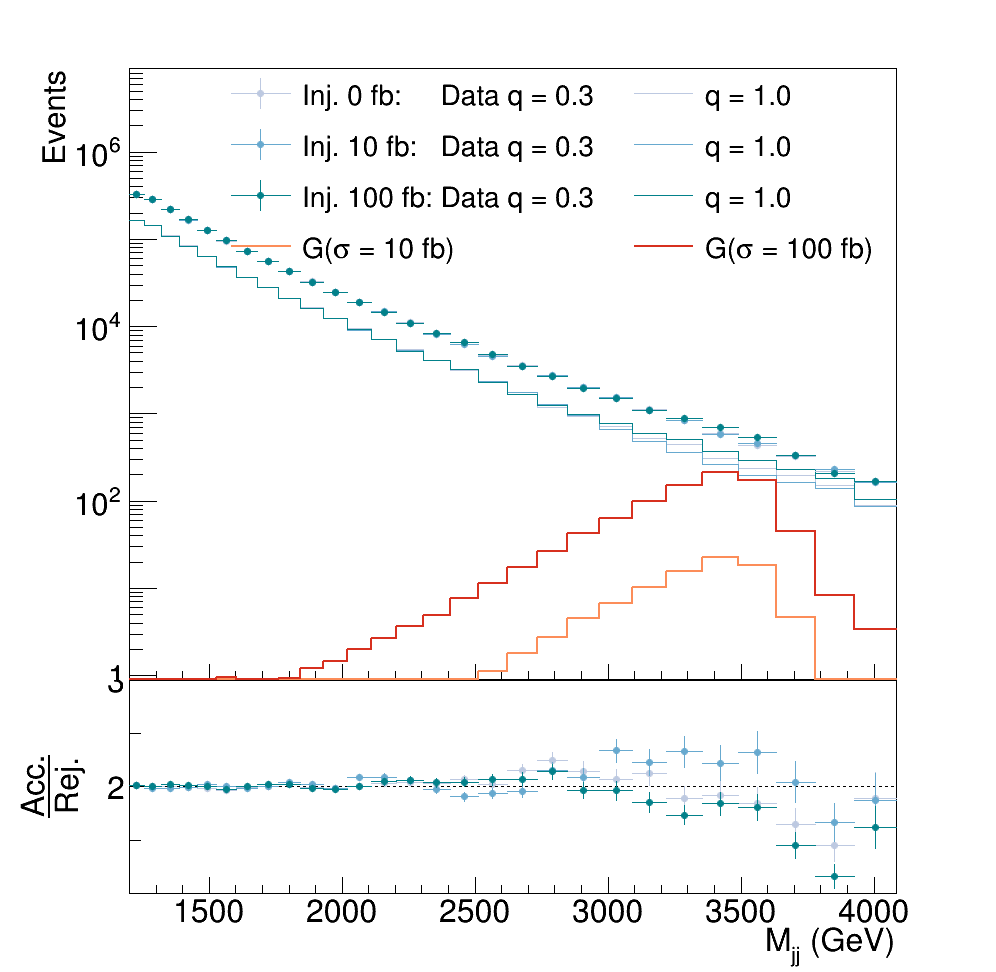

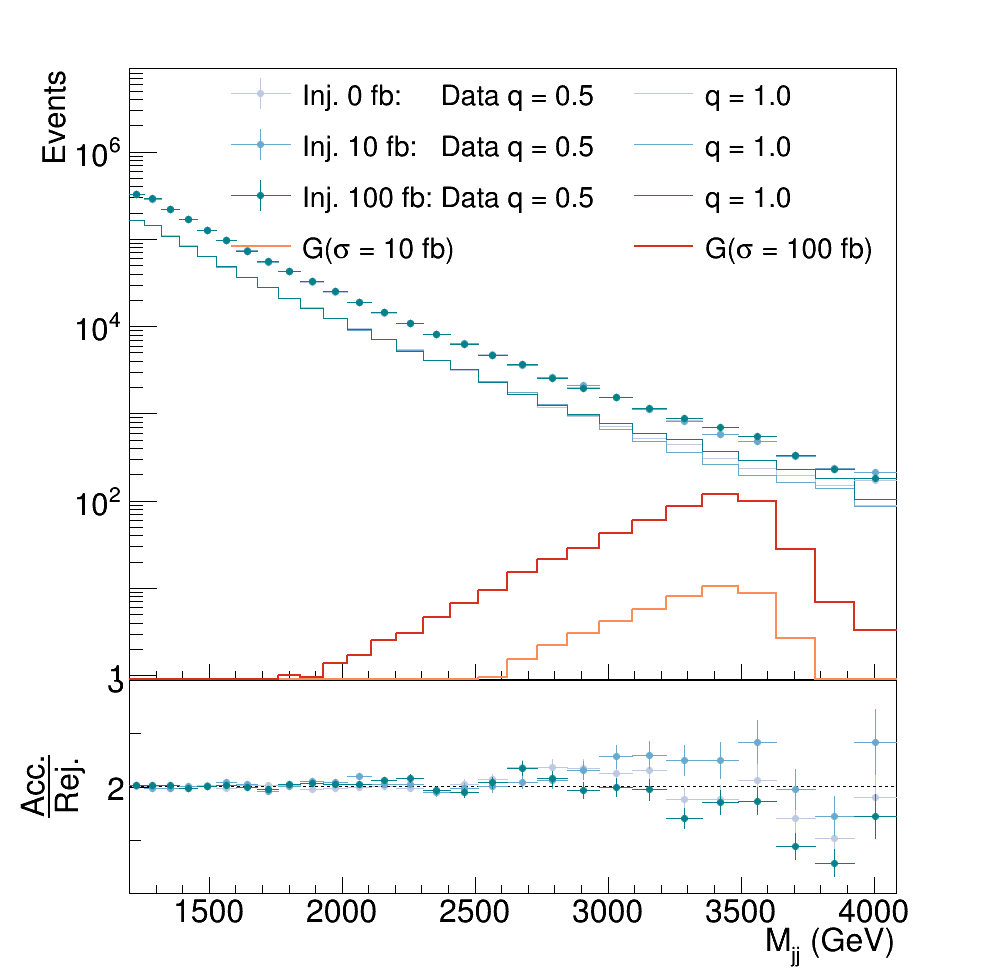

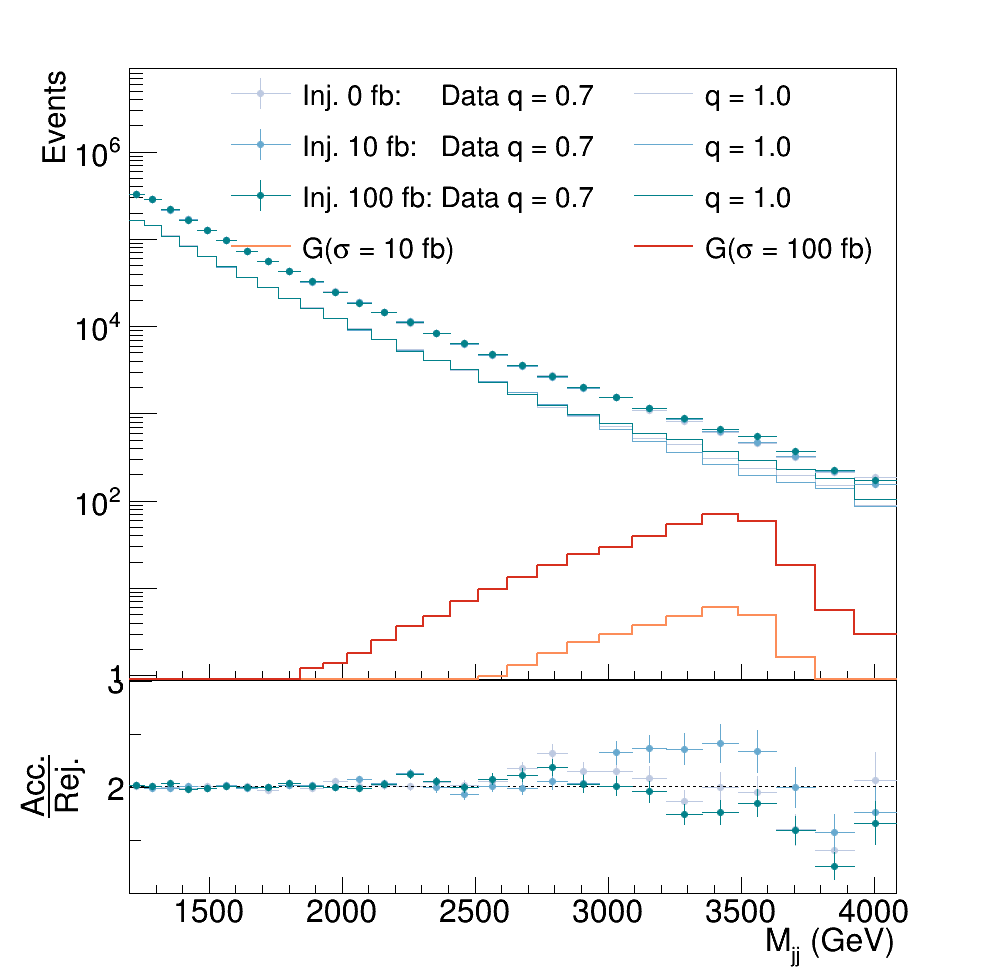

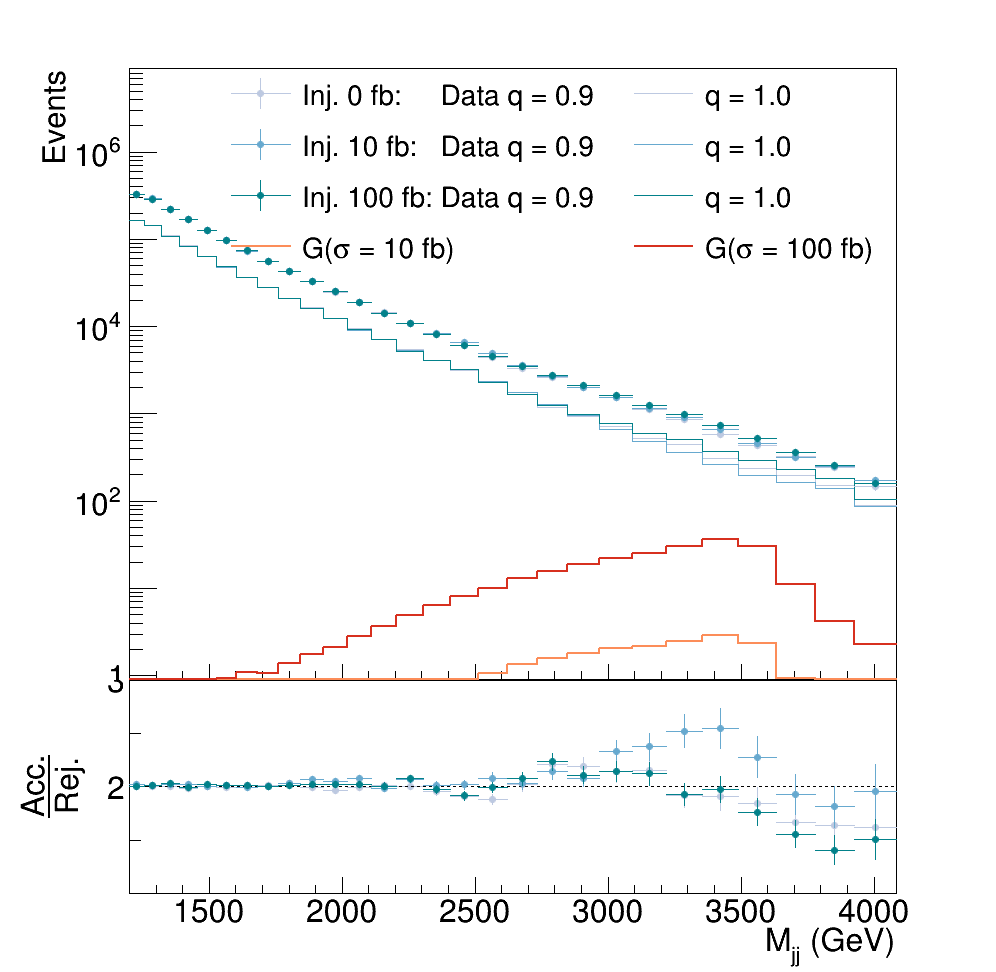

In [10]:
canvs = []
c0,l0,t0,h0 = drawHistos(qPass=0.01,qFail=1.0); canvs.append([c0,l0,t0,h0]);canvs[0][0].Draw()
c1,l1,t1,h1 = drawHistos(qPass=0.1,qFail=1.0) ; canvs.append([c1,l1,t1,h1]);canvs[1][0].Draw()
c2,l2,t2,h2 = drawHistos(qPass=0.3,qFail=1.0) ; canvs.append([c2,l2,t2,h2]);canvs[2][0].Draw()
c3,l3,t3,h3 = drawHistos(qPass=0.5,qFail=1.0) ; canvs.append([c3,l3,t3,h3]);canvs[3][0].Draw()
c4,l4,t4,h4 = drawHistos(qPass=0.7,qFail=1.0) ; canvs.append([c4,l4,t4,h4]);canvs[4][0].Draw()
c5,l5,t5,h5 = drawHistos(qPass=0.9,qFail=1.0) ; canvs.append([c5,l5,t5,h5]);canvs[5][0].Draw()

In [11]:
# Make sure the data is correctly created and store all histograms to file (will be imported to workspace below)

outfile = rt.TFile("histograms.root", 'RECREATE' )

for xs in xsecs:
    print("\nFor xsec={}:".format(xs) )
    scaled_histos_signal[xs][1.0].Write('signal_acc_{}fb_q{}p'.format(xs,100))   
    scaled_histos_data[xs][1.0].Write('data_acc_{}fb_q{}p'.format(xs,100))
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
#         print('SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format( scaled_histos_signal[xs][key].Integral(),scaled_histos_signal_rej[xs][key].Integral(), scaled_histos_data[xs][key].Integral(),scaled_histos_data_rej[xs][key].Integral()))
        scaled_histos_signal[xs][key].Write('signal_acc_{}fb_q{}p'.format(xs,quantile))
#         scaled_histos_signal_rej[xs][key].Write('signal_rej_{}fb_q{}p'.format(xs,quantile))
        
        scaled_histos_data[xs][key].Write('data_acc_{}fb_q{}p'.format(xs,quantile))
#         scaled_histos_data_rej[xs][key].Write('data_rej_{}fb_q{}p'.format(xs,quantile))

outfile.Close() 


For xsec=0:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=10:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9

For xsec=100:
For q = 0.01
For q = 0.1
For q = 0.3
For q = 0.5
For q = 0.7
For q = 0.9


In [12]:
def makeWS(data_rej,data_acc,signal_rej,signal_acc, outname,qr_unc_file):
  
  efficiency = data_acc.Integral()/data_rej.Integral() #How much rej histogram needs to be scaled to match acc
  print('Using efficiency = {} '.format(efficiency))
 
  xaxis = data_acc.GetXaxis().GetXbins()
  min_bin = xaxis[0]
  max_bin = xaxis[len(xaxis)-1]
  n_bins  = len(xaxis)-1
  
  # set up workspace
  datacard_ws = rt.TFile.Open(outname,'recreate')
  w = rt.RooWorkspace('w','w')
  x = rt.RooRealVar('x','x',min_bin,max_bin)
  w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

  acc_bin_functions = rt.RooArgList()
  rej_bin_functions = rt.RooArgList()
    
  w.factory('eff[%f]'%(efficiency))
  w.var('eff').setConstant(True)

  
  empty_hist = rt.TH1D('empty_hist','empty_hist', data_rej.GetNbinsX(), data_rej.GetXaxis().GetXbins().GetArray())

  for iBinX in range(1,data_rej.GetNbinsX()+1):
      empty_hist.SetBinContent(iBinX,1)
      rej_bin = data_rej.GetBinContent(iBinX)
      
      # Uncertainty on yield in reject based on QR envelope: qr_rms/qr_cutValue
#       rms_qr = qr_unc_file['q90'][iBinX-1][2]/qr_unc_file['q90'][iBinX-1][1]
#       rms_qr = 0.064
#       print('crBin%i_In[%.1f,%.1f,%.1f]'%(iBinX,rej_bin,rej_bin*(1-rms_qr),rej_bin*(1+rms_qr)))
#       w.factory('crBin%i_In[%.1f,%.1f,%.1f]'%(iBinX,rej_bin,rej_bin*(1-rms_qr),rej_bin*(1+rms_qr)))
      w.factory('crBin%i_In[%.1f]'%(iBinX,rej_bin))
      w.factory('crBin%i[0,-100,100]'%(iBinX))
      w.var('crBin%i_In'%iBinX).setConstant(True)
      w.var('crBin%i'%iBinX).setConstant(False)
      if rej_bin !=  0.:
        power = 1/rt.TMath.Sqrt(rej_bin)
      else:
        power = -1.0
        w.var('crBin%i'%iBinX).setConstant(True)
        w.var('crBin%i_In'%iBinX).setConstant(True)
      #what is fit is actually (mjj+mjj/sqrt(mjj))^x_bin, meaning x_bin is representative of how many sigma acc is from rej
      w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,power,iBinX,iBinX))
#       effDown = efficiency*(1-0.063)
#       effUp   = efficiency*(1+0.063)
#       w.factory('eff%i[%f,%f,%f]'%(iBinX,efficiency,effDown,effUp))

#       if data_rej.GetBinContent(iBinX) !=  0.:
#         w.var('eff%i'%iBinX).setConstant(False)
#       else:
#          w.var('eff%i'%iBinX).setConstant(True)
#       w.factory("expr::bin%iFunc('max(0,@0*@1)',eff%i,crBin%iFunc)"%(iBinX,iBinX,iBinX))
    
      w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
      rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
      acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
  qcd_rph_rej = rt.RooParametricHist('background_rej','background_rej',w.var('x'),rej_bin_functions,empty_hist)
  qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
  qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
  qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
  getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
  getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
  getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
  getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

  ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_acc)
  ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_rej)
  getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
  getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

  ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_acc)
  ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_rej)
  getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
  getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

  datacard_ws.cd()
  w.Write()
  datacard_ws.Close()

  # w.Print('v')
  
  datacard_ratio = \
  '''
  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * {WS} w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin {BIN}
  observation {OBS}
  ------------------------------
  bin             {BIN}      {BIN}
  process         signal     background
  process         0          1
  rate            {SIGRATE}    {BKGRATE}
  --------------------------------
  lumi lnN 1.01 -
  '''
  datacard_ratio += 'eff   flatParam\n'
#   for i in range(1,n_bins+1):
#       datacard_ratio += 'eff%i   flatParam\n'%i
  for i in range(1,n_bins+1):
      datacard_ratio += 'crBin%i   flatParam\n'%i
#   for i in range(1,n_bins+1):
#       datacard_ratio += 'crBin%i_In   flatParam\n'%i
  # write datacard
  datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                            OBS=-1,
                            BKGRATE=1,
                            SIGRATE=signal_acc.Integral(),
                            WS=outname)
  print(datacard_ratio_acc)
  with open(outname.replace('.root','_acc.txt'),'w') as f:
      f.write(datacard_ratio_acc)
    
    
  datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                            OBS=-1,
                            BKGRATE=1,
                            SIGRATE=signal_rej.Integral(),
                            WS=outname)
  print(datacard_ratio_rej)
  with open(outname.replace('.root','_rej.txt'),'w') as f:
      f.write(datacard_ratio_rej)
  os.system('combineCards.py rej={REJ} acc={ACC} > {RATIO}'.format(REJ=outname.replace('.root','_rej.txt'),ACC=outname.replace('.root','_acc.txt'),RATIO=outname.replace('.root','_ratio.txt')))

In [13]:
import json
  
# Opening JSON file with QR uncert.
f = open('/eos/project/d/dshep/TOPCLASS/DijetAnomaly/QR_models/envelope/cut_stats.json',)
qr_unc = json.load(f)
f.close()


In [14]:
for xs in xsecs:
    print("\nFor xsec={}:".format(xs) )
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        # Get histograms
        f = rt.TFile.Open('histograms.root',"r")
        data_acc = f.Get('data_acc_{}fb_q{}p'.format(xs,quantile)); data_acc.SetDirectory(0);
        data_rej = f.Get('data_acc_{}fb_q100p'.format(xs)); data_rej.SetDirectory(0);

        signal_acc     = f.Get('signal_acc_{}fb_q{}p'.format(xs,quantile)); signal_acc.SetDirectory(0);
        signal_rej     = f.Get('signal_acc_{}fb_q100p'.format(xs)); signal_rej.SetDirectory(0);
        f.Close() 

        print('XS={}: SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format(xs,signal_acc.Integral(),signal_rej.Integral(), data_acc.Integral(),data_rej.Integral()))
        xaxis = data_acc.GetXaxis().GetXbins()
        min_bin = xaxis[0]
        max_bin = xaxis[len(xaxis)-1]
        n_bins  = len(xaxis)-1

        prefix = "q{}_xs{}".format(quantile,xs)
        makeWS(data_rej,data_acc,signal_rej,signal_acc, outname='datacard_ws_{PREFIX}.root'.format(PREFIX=prefix), qr_unc_file=qr_unc)


For xsec=0:
For q = 0.01
XS=0: SIG PASS = 0.0959300598934 SIG FAIL = 0.119472891038 BKG PASS = 76715.0 BKG FAIL = 766026.0
Using efficiency = 0.100146731312 

  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * datacard_ws_q1_xs0.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin acc
  observation -1
  ------------------------------
  bin             acc      acc
  process         signal     background
  process         0          1
  rate            0.0959300598934    1
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin


  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * datacard_ws_q70_xs0.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin rej
  observation -1
  ------------------------------
  bin             rej      rej
  process         signal     background
  process         0          1
  rate            0.119472891038    1
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam

For q = 0.9
XS=0: SIG P


  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * datacard_ws_q30_xs10.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin rej
  observation -1
  ------------------------------
  bin             rej      rej
  process         signal     background
  process         0          1
  rate            9.51191460048    1
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam

For q = 0.5
XS=10: SIG 


  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * datacard_ws_q1_xs100.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin rej
  observation -1
  ------------------------------
  bin             rej      rej
  process         signal     background
  process         0          1
  rate            106.661504732    1
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam

For q = 0.1
XS=100: SIG


  imax 1
  jmax 1
  kmax *
  ---------------
  shapes * * datacard_ws_q70_xs100.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
  ---------------
  bin rej
  observation -1
  ------------------------------
  bin             rej      rej
  process         signal     background
  process         0          1
  rate            106.661504732    1
  --------------------------------
  lumi lnN 1.01 -
  eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam

For q = 0.9
XS=100: SI

In [16]:
# for xs in xsecs:
#     for 
    
#     # Get histograms
#     f = rt.TFile.Open('histograms.root',"r")
#     data_acc = f.Get('data_acc_{}fb_q30p'.format(xs)); data_acc.SetDirectory(0);
#     data_rej = f.Get('data_rej_{}fb_q70p'.format(xs)); data_rej.SetDirectory(0);
    
#     signal_acc     = f.Get('signal_acc_{}fb_q30p'.format(xs)); signal_acc.SetDirectory(0);
#     signal_rej     = f.Get('signal_rej_{}fb_q70p'.format(xs)); signal_rej.SetDirectory(0);
#     f.Close() 
    
#     print('XS={}: SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format(xs,signal_acc.Integral(),signal_rej.Integral(), data_acc.Integral(),data_rej.Integral()))
#     xaxis = data_acc.GetXaxis().GetXbins()
#     min_bin = xaxis[0]
#     max_bin = xaxis[len(xaxis)-1]
#     n_bins  = len(xaxis)-1
    
#     prefix = "q30_xs{}".format(xs)
#     makeWS(data_rej,data_acc,signal_rej,signal_acc, outname='datacard_ws_{PREFIX}.root'.format(PREFIX=prefix), qr_unc_file=qr_unc)

In [17]:
# # Observed GOF
# os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_q10_xs0_ratio.txt -n Ratio_GOF --dataset data_obs -v 2'.format(PREFIX=prefix))

In [18]:
# for xs in xsecs:
    
#     # Get histograms
#     f = rt.TFile.Open('histograms.root',"r")
#     data_acc = f.Get('data_acc_{}fb_q50p'.format(xs)); data_acc.SetDirectory(0);
#     data_rej = f.Get('data_rej_{}fb_q50p'.format(xs)); data_rej.SetDirectory(0);
    
#     signal_acc     = f.Get('signal_acc_{}fb_q50p'.format(xs)); signal_acc.SetDirectory(0);
#     signal_rej     = f.Get('signal_rej_{}fb_q50p'.format(xs)); signal_rej.SetDirectory(0);
#     f.Close() 
    
#     print('XS={}: SIG PASS = {} SIG FAIL = {} BKG PASS = {} BKG FAIL = {}'.format(xs,signal_acc.Integral(),signal_rej.Integral(), data_acc.Integral(),data_rej.Integral()))
#     xaxis = data_acc.GetXaxis().GetXbins()
#     min_bin = xaxis[0]
#     max_bin = xaxis[len(xaxis)-1]
#     n_bins  = len(xaxis)-1
    
#     prefix = "q50_xs{}".format(xs)
#     makeWS(data_rej,data_acc,signal_rej,signal_acc, outname='datacard_ws_{PREFIX}.root'.format(PREFIX=prefix), qr_unc_file=qr_unc)

In [19]:
# prefix = 'q70_xs0'
# os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -n Ratio_gof_{PREFIX} --dataset data_obs -v 2'.format(PREFIX=prefix))
# os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -t 10 --toysFreq -n Ratio_gof_toys_{PREFIX}  --dataset data_obs -s {S} -v 0'.format(PREFIX=prefix,S=40))

In [ ]:
for xs in xsecs:
    print("\nFor xsec={}:".format(xs) )
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}".format(quantile,xs)
        os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -n Ratio_gof_{PREFIX} --dataset data_obs -v 2'.format(PREFIX=prefix))
        
        for i in range(10):
          os.system('combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ws_{PREFIX}_ratio.txt -t 100 --toysFreq -n Ratio_gof_toys_{PREFIX}  --dataset data_obs -s {S} -v 0'.format(PREFIX=prefix,S=40+i))
        os.system('hadd -f higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.4*.root'.format(PREFIX=prefix))

        # open file
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

        print("Obs gof = {}".format(obs_gof))

        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix))
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        print("Exp gof (mean) = {}".format(np.mean(exp_gof)))


For xsec=0:
For q = 0.01
Obs gof = 80.0106653441
Exp gof (mean) = 28.3060089786
For q = 0.1
Obs gof = 80.8596335165
Exp gof (mean) = 27.7907450542
For q = 0.3
Obs gof = 68.4229945056
Exp gof (mean) = 27.955285537
For q = 0.5
Obs gof = 55.4676412567
Exp gof (mean) = 27.8877615809
For q = 0.7
Obs gof = 68.863368623
Exp gof (mean) = 28.2915118422
For q = 0.9
Obs gof = 53.0238166489
Exp gof (mean) = 27.9264737566

For xsec=10:
For q = 0.01
Obs gof = 48.8441076223
Exp gof (mean) = 28.3618074647
For q = 0.1
Obs gof = 79.113682434
Exp gof (mean) = 27.9704556483
For q = 0.3
Obs gof = 100.585807443
Exp gof (mean) = 27.7181603287
For q = 0.5
Obs gof = 98.7557312436
Exp gof (mean) = 27.8703348232
For q = 0.7
Obs gof = 94.0912545733
Exp gof (mean) = 27.8316203325
For q = 0.9
Obs gof = 78.9507126361
Exp gof (mean) = 27.7640363454

For xsec=100:
For q = 0.01
Obs gof = 108.159720792
Exp gof (mean) = 27.7591557514
For q = 0.1
Obs gof = 128.048443582
Exp gof (mean) = 27.880922219
For q = 0.3
Obs gof =


For xsec=0:
For q = 0.01
rej
rej bin 0: fi=14245.0253906, di=296976.363636, gofi=1238517.15678
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=10660.7558594, di=222296.923077, gofi=927156.868193
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=7830.62939453, di=163386.567164, gofi=681649.767951
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=5759.37744141, di=120162.857143, gofi=501307.025795
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4207.71386719, di=87669.4444444, gofi=365520.068888
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3106.54443359, di=65090.6666667, gofi=272078.543395
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2264.52636719, di=47505.1948052, gofi=198680.260591
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1665.80651855, di=35008.75, gofi=146537.609588
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1221.56787109, di=25566.2650602, gofi=106

rej
rej bin 0: fi=13024.6826172, di=296976.363636, gofi=1289271.78638
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=9701.484375, di=222296.923077, gofi=967159.265798
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=7126.05664062, di=163386.567164, gofi=711050.386115
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=5225.06542969, di=120162.857143, gofi=523637.009726
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=3801.99169922, di=87669.4444444, gofi=382487.008615
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=2804.78588867, di=65090.6666667, gofi=284777.448307
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2071.36474609, di=47505.1948052, gofi=206764.867964
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1528.10876465, di=35008.75, gofi=152303.221223
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1122.57946777, di=25566.2650602, gofi=110934.744341
 -> BIG GOF CONTR

rej
rej bin 0: fi=13622.8291016, di=296976.363636, gofi=1263799.14115
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=10197.1933594, di=222296.923077, gofi=945994.963237
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=7475.63916016, di=163386.567164, gofi=696099.860824
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=5474.90820312, di=120162.857143, gofi=512911.516434
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4027.79418945, di=87669.4444444, gofi=372822.64369
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=2987.58325195, di=65090.6666667, gofi=276923.708739
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2180.62060547, di=47505.1948052, gofi=202099.671785
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1587.4654541, di=35008.75, gofi=149753.720239
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1175.50634766, di=25566.2650602, gofi=108684.929828
 -> BIG GOF CONTR

rej
rej bin 0: fi=11382.2998047, di=296451.051136, gofi=1362618.17929
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=8575.60449219, di=223377.043269, gofi=1026788.47644
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=6263.5390625, di=163253.871269, gofi=750617.783282
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=4572.49023438, di=119217.310268, gofi=548219.429431
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=3365.43676758, di=87473.7792969, gofi=401724.205303
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=2459.04150391, di=64037.5104167, gofi=294328.870808
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=1823.89672852, di=47546.9561688, gofi=218630.642737
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1338.49768066, di=35027.7319336, gofi=161324.055031
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=976.824523926, di=25508.6761107, gofi=117378.71896
 -> BIG GOF 

rej
rej bin 0: fi=16439.5839844, di=296451.051136, gofi=1154762.61565
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=12250.6494141, di=223377.043269, gofi=874800.38688
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=8971.91113281, di=163253.871269, gofi=638702.879329
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=6568.03222656, di=119217.310268, gofi=465859.910305
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4869.83544922, di=87473.7792969, gofi=340089.460593
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3544.29638672, di=64037.5104167, gofi=249679.249007
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2609.66796875, di=47546.9561688, gofi=186135.007338
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1933.82055664, di=35027.7319336, gofi=136737.809806
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1426.33520508, di=25508.6761107, gofi=98964.7843556
 -> BIG GOF

rej
rej bin 0: fi=16317.7792969, di=296451.051136, gofi=1158928.31037
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=12171.2636719, di=223377.043269, gofi=877546.058591
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=8890.50585938, di=163253.871269, gofi=641516.109044
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=6536.75537109, di=119217.310268, gofi=466935.490161
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4764.80908203, di=87473.7792969, gofi=343693.733196
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3520.2878418, di=64037.5104167, gofi=250501.745066
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2589.60327148, di=47546.9561688, gofi=186828.842358
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1919.05285645, di=35027.7319336, gofi=137245.309
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1405.6895752, di=25508.6761107, gofi=99667.3453661
 -> BIG GOF CON

rej
rej bin 0: fi=16498.5039062, di=296346.988636, gofi=1152158.12101
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=12310.5634766, di=221847.331731, gofi=863883.664587
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=8960.45410156, di=161238.724347, gofi=627424.285973
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=6676.65673828, di=119924.508929, gofi=466247.041047
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4855.12011719, di=87653.0924479, gofi=341626.740119
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3574.11767578, di=64779.1145833, gofi=252954.516559
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2634.26855469, di=47660.450487, gofi=185948.958759
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1934.19714355, di=34953.5742188, gofi=136295.491116
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1418.89611816, di=25486.7611069, gofi=99090.0725883
 -> BIG GOF

rej
rej bin 0: fi=15285.0048828, di=296346.988636, gofi=1195011.4194
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=11399.1396484, di=221847.331731, gofi=896189.734981
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=8354.80273438, di=161238.724347, gofi=648781.359616
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=6179.56152344, di=119924.508929, gofi=483809.982543
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4508.44140625, di=87653.0924479, gofi=353920.474175
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3301.99438477, di=64779.1145833, gofi=262670.205975
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2453.10229492, di=47660.450487, gofi=192378.439534
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1808.70629883, di=34953.5742188, gofi=140733.915185
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1318.88024902, di=25486.7611069, gofi=102616.0069
 -> BIG GOF CO

rej
rej bin 0: fi=16017.5888672, di=296346.988636, gofi=1168729.53119
 -> BIG GOF CONTRIBUTION in this bin, mjj 1227.5
rej bin 1: fi=11973.2285156, di=221847.331731, gofi=875536.83462
 -> BIG GOF CONTRIBUTION in this bin, mjj 1287.5
rej bin 2: fi=8771.30859375, di=161238.724347, gofi=633926.018727
 -> BIG GOF CONTRIBUTION in this bin, mjj 1353.5
rej bin 3: fi=6411.20703125, di=119924.508929, gofi=475446.772243
 -> BIG GOF CONTRIBUTION in this bin, mjj 1422.0
rej bin 4: fi=4704.94189453, di=87653.0924479, gofi=346834.577479
 -> BIG GOF CONTRIBUTION in this bin, mjj 1493.0
rej bin 5: fi=3489.80957031, di=64779.1145833, gofi=255878.607038
 -> BIG GOF CONTRIBUTION in this bin, mjj 1566.5
rej bin 6: fi=2564.73461914, di=47660.450487, gofi=188359.776859
 -> BIG GOF CONTRIBUTION in this bin, mjj 1642.5
rej bin 7: fi=1881.79504395, di=34953.5742188, gofi=138110.770329
 -> BIG GOF CONTRIBUTION in this bin, mjj 1721.0
rej bin 8: fi=1386.5447998, di=25486.7611069, gofi=100201.038088
 -> BIG GOF C

Info in <TCanvas::Print>: pdf file q1_xs0_gof.pdf has been created
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-PFxLZV.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Warning! -- You haven't picked default values for the Parameters of Interest (either with --expectSignal or --setParameters) for generating toys. Combine will use the 'B-only' ModelConfig to generate, which may lead to undesired behaviour if not using the default Physics Model
Info in <TCanvas::Print>: pdf file q1_xs0_fitResults.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ratio
Info in <TCanvas::Print>: pdf file q10_xs0_gof.pdf has been created
Missing background ModelConfig 'ModelConfig_bonly' in workspace 'w' in file roostats-LNFLLe.root
Will make one from the signal ModelConfig 'ModelConfig' setting signal strenth 'r' to zero
Warning! -- You haven't picked default values for the Parameters

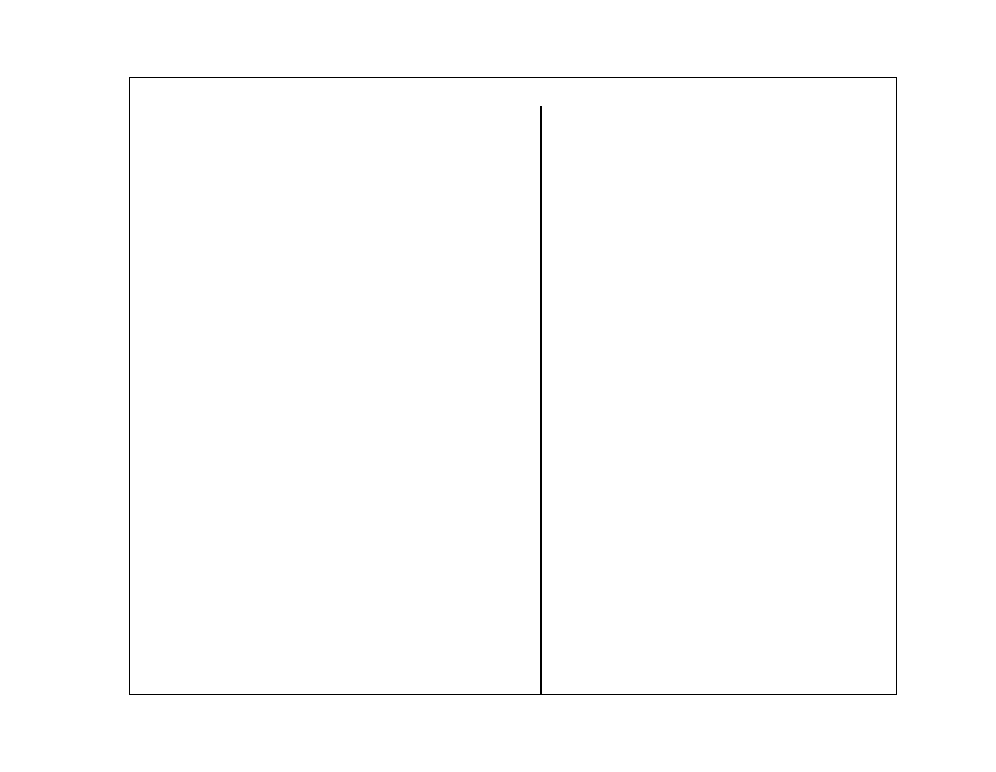

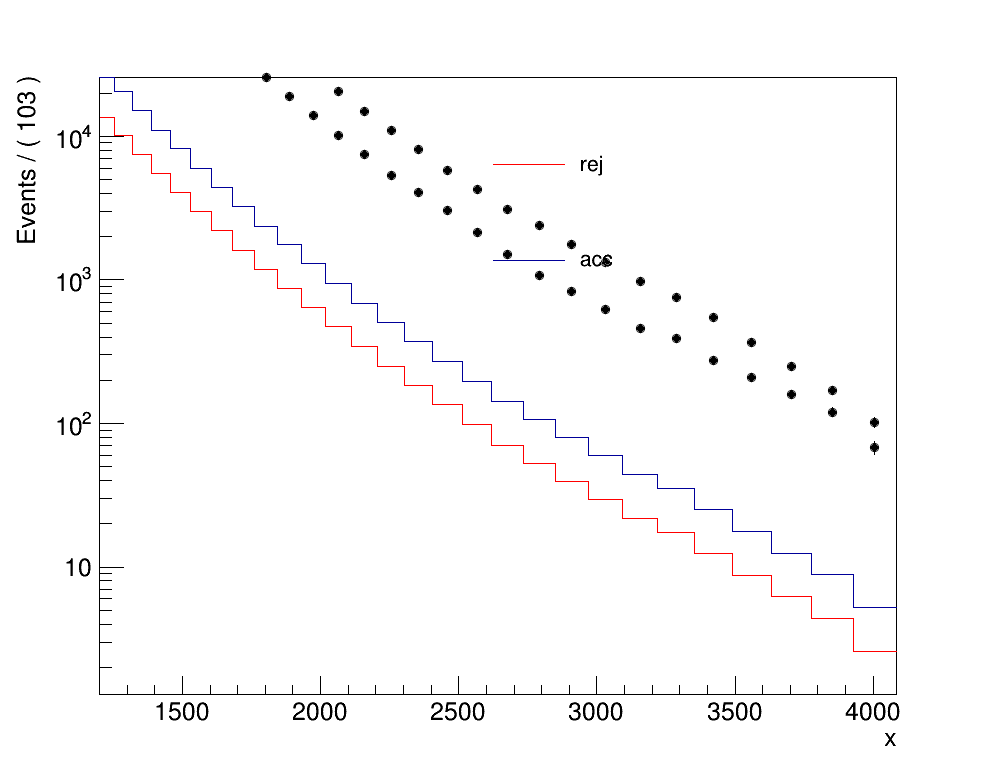

In [21]:
# open file
for xs in xsecs:
    print("\nFor xsec={}:".format(xs) )
    for key in sorted(columns.keys()):
        print("For q = {}".format(key) )
        quantile = int(key*100)
        prefix = "q{}_xs{}".format(quantile,xs)
    
        obs_gof_file = uproot.open('higgsCombineRatio_gof_{PREFIX}.GoodnessOfFit.mH120.root'.format(PREFIX=prefix))
        obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

        exp_gof_file = uproot.open('higgsCombineRatio_gof_toys_{PREFIX}.GoodnessOfFit.mH120.ALLTOYS.root'.format(PREFIX=prefix)) #limit contains the value of the test-statistic in each toy
        exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

        # get p-value from toys
        n_extreme = len(exp_gof[exp_gof > obs_gof])
        n_total = len(exp_gof)
        pval_toys = 1.*n_extreme/n_total
        # get p-value assuming chi2 dist (may not be valid)
        pval = rt.TMath.Prob(obs_gof,n_bins)
        # print('sig inj = %.1f fb, gof = %.2f, p-value (from chi2) = %.6f, p-value (from toys) = %.6f'%(sig_inj*sig_xsec,obs_gof,pval,pval_toys))

        bin_width = (max(exp_gof+[obs_gof])+np.std(exp_gof)-(min(exp_gof)-np.std(exp_gof)))/30.
        exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-np.std(exp_gof), max(exp_gof+[obs_gof])+np.std(exp_gof))
        for g in exp_gof:
            exp_gof_hist.Fill(g)
            if g > obs_gof:
                exp_gof_hist_gt.Fill(g)


        d = rt.TCanvas("ratio", "", 1000, 800)
        d.SetLeftMargin(0.13)
        # signal_hist_template    .Draw('same HIST')

        rt.gStyle.SetOptTitle(0)
        rt.gStyle.SetOptStat(0)
        f = rt.TF1("chi2","%f*ROOT::Math::chisquared_pdf(x,%i,0)"%(exp_gof_hist.Integral()*bin_width,n_bins),min(exp_gof)-np.std(exp_gof),max(exp_gof+[obs_gof])+np.std(exp_gof))

        tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
        tleg.SetTextSize(0.05)
        tleg.SetBorderSize(0)
        tleg.SetFillStyle(0)
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 62 )
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 42 )
        exp_gof_hist.Draw('hist')
        exp_gof_hist.SetXTitle('Test statistic -2ln#lambda')
        exp_gof_hist.SetYTitle('N toys')
        exp_gof_hist.SetTitle("")
        exp_gof_hist.GetYaxis().SetLabelSize(0.05)
        exp_gof_hist.GetYaxis().SetTitleSize(0.05)
        f.SetLineColor((rt.TColor.GetColor(scol[1])))
        exp_gof_hist.SetLineWidth(2)
        exp_gof_hist.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetLineColor((rt.TColor.GetColor(bcol[0])))
        exp_gof_hist_gt.SetFillColorAlpha((rt.TColor.GetColor(bcol[0])), 0.30)
        exp_gof_hist_gt.Draw('fhistsame')
        f.Draw('same')
        line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
        line.SetLineWidth(2)
        line.Draw()
        tleg.AddEntry(None,"{} fb injected".format(xs),"")
        tleg.AddEntry(exp_gof_hist_gt,'p-value (from toys) = %.2f'%pval_toys)
        tleg.AddEntry(f,'p-value (from #chi^{2}) = %.2f'%pval,'l')
        tleg.AddEntry(line,'Observed test stat. = {:.1f})'.format(obs_gof),'l')
        tleg.Draw()
        latex = rt.TLatex()
        latex.SetNDC ()
        latex.SetTextSize (0.03)
        latex.SetTextFont( 62 )
        # latex.DrawLatex (0.67 ,0.27 , "%.1f fb^{-1} dijet events"%lumi)
        latex.SetTextSize (0.03)
        latex.SetTextFont( 42 )
        # latex.DrawLatex(0.67 ,0.23 , 'q = {} - {}'.format(lower_bound,qkey))
        d.Draw()
        d.SaveAs("{}_gof.pdf".format(prefix))
        
        #DEBUG! Plot fit results!

        os.system('combine -M FitDiagnostics -d datacard_ws_{PREFIX}_ratio.txt -n _fit_result_{PREFIX} --saveShapes --saveWithUncertainties --dataset data_obs'.format(PREFIX=prefix))
        fitDiag = rt.TFile.Open('fitDiagnostics_fit_result_{PREFIX}.root'.format(PREFIX=prefix),'r')


        f = rt.TCanvas('f','f',1000,800)
        f.cd()

        tleg = rt.TLegend(0.48, 0.6, 0.89, 0.85)
        tleg.SetTextSize(0.05)
        tleg.SetBorderSize(0)
        tleg.SetFillStyle(0)
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 62 )
        tleg.SetTextSize (0.03)
        tleg.SetTextFont( 42 )

        byhand_gof = 0.0
        for cat in ['rej', 'acc']:
            print cat
            bkgd = fitDiag.Get('shapes_fit_b/{cat}/background'.format(cat=cat))
            bkgd.Scale(bin_width) # need to multiply by bin width for some reason?
            data = fitDiag.Get('shapes_fit_b/{cat}/data'.format(cat=cat))
            if cat=='rej':
                bkgd.Draw('hist')
                bkgd.SetLineColor(rt.kRed)
        #         bkgd.SetMinimum(10E3)
        #         bkgd.SetMaximum(20E3)
        #         bkgd.GetXaxis().SetRangeUser(2600,2800)
                tleg.AddEntry(bkgd,'rej','l')
            else:
                bkgd.Draw("histsame")
                tleg.AddEntry(bkgd,'acc','l')
            data.SetMarkerStyle(20)
            data.SetMarkerColor(rt.kBlack)
            for i in range(0,bkgd.GetNbinsX()):
                data.SetPointEXlow(i,0)
                data.SetPointEXhigh(i,0)
                data.SetPoint(i,data.GetX()[i], 100*data.GetY()[i]) # need to multiply by bin width for some reason?
                data.SetPointEYlow(i,100*data.GetErrorYlow(i)) # need to multiply by bin width for some reason?
                data.SetPointEYhigh(i,100*data.GetErrorYhigh(i)) # need to multiply by bin width for some reason?
            data.Draw('samepez')


            for i in range(0,bkgd.GetNbinsX()):
                mjjvalue = bkgd.GetBinCenter(i+1)
                fi = bkgd.GetBinContent(i+1)
                di = data.GetY()[i]
                if di == 0:
                    print ("No data at mjj", mjjvalue)
                    print ("fi", fi)
                    print ("di", di)
                    gofi = 0.
                else:    
                    gofi = 2*(fi - di + di*rt.TMath.Log(di/fi)) # see eq. 14 of http://cousins.web.cern.ch/cousins/ongoodness6march2016.pdf
                # expect each bin to give GOF contribution ~ O(1)
                if gofi>5:
                    print('{cat} bin {i}: fi={fi}, di={di}, gofi={gofi}'.format(cat=cat,i=i,fi=fi,di=di,gofi=gofi))
                    print(" -> BIG GOF CONTRIBUTION in this bin, mjj {}".format(mjjvalue))
                byhand_gof += gofi

        tleg.Draw('same')
        f.SetLogy()
        f.Draw()
        f.SaveAs("{}_fitResults.pdf".format(prefix))

        print("Done with quantile ",prefix )

        print("By hand obs GOF = {}".format(byhand_gof))
        print("Combine obs GOF = {}".format(obs_gof))
        # print("Combine exp GOF (mean) = {}".format(np.mean(exp_gof)))

        # print("p-value = {}".format(pval_toys))

